In [1]:
#r "nuget: Microsoft.SemanticKernel, 0.11.146.1-preview"
#r "nuget: SkiaSharp, 2.88.3"
// #r "D:\Repos\public\interactive\src\Microsoft.DotNet.Interactive.OpenAI\bin\Debug\net7.0\Microsoft.DotNet.Interactive.OpenAI.dll"
#r "C:\dev\interactive\src\Microsoft.DotNet.Interactive.OpenAI\bin\Debug\net7.0\Microsoft.DotNet.Interactive.OpenAI.dll"
Microsoft.DotNet.Interactive.OpenAI.OpenAIKernelConnector.AddKernelConnectorToCurrentRootKernel();

Installed Packages Microsoft.SemanticKernel, 0.11.146.1-preview SkiaSharp, 2.88.3

Loading extensions from `C:\Users\josequ\.nuget\packages\skiasharp\2.88.3\interactive-extensions\dotnet\SkiaSharp.DotNet.Interactive.dll`

In [2]:
#!connect openai --kernel-name openai

Kernel added: #!openai(chat)

Kernel added: #!openai(text)

Kernel added: #!openai(embedding)

Kernel added: #!openai(image)

Kernel added: #!openai(skill)

## DALL-E


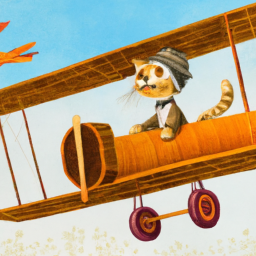

In [3]:
A movie still of a very smartly-dressed calico cat flying a red biplane. Do this in the style of Hiyao Miyazaki.

### *Point of interest* 

Extensions are able to provide custom visualizations. 

[Our code](https://github.com/jonsequitur/interactive/blob/3f4a7ad291782901e2c0091398682b17396c2314/src/Microsoft.DotNet.Interactive.OpenAI/SkiaUtils.cs#L26)

[SkiaSharp's code](https://github.com/mono/SkiaSharp/blob/main/source/SkiaSharp.DotNet.Interactive/SkiaSharpKernelExtension.cs)

## Skills

In [4]:
#!function summarize --skill writer
{{$input}}
Summarize the text above.

In [5]:
#!function stylist --skill writer
{{$input}}
Rewrite the text above in the style of {{$person}}

In [13]:
#!function make_image_prompt --skill image
{{$input}}
Describe an image of the text above in {{$linecount}} lines.

In [14]:
#!function improve --skill image
{{$input}}
Turn the text above into a better prompt for DALL-E.

## Chaining models programmatically

In [18]:
using Microsoft.DotNet.Interactive;
using Microsoft.DotNet.Interactive.Commands;
using Microsoft.DotNet.Interactive.Events;

var prompts = new List<string>();

Kernel.Root.KernelEvents.Subscribe(e =>
{
    if (e is ReturnValueProduced rvp &&
        e.Command.TargetKernelName.Contains("openai") &&
        rvp.FormattedValues.SingleOrDefault(v => v.MimeType == "text/plain") is { } plainTextValue)
    {
        prompts.Add(plainTextValue.Value);
    }
});

In [21]:
#!set --name linecount --value 10
#!prompt function.image.make_image_prompt function.image.improve

A cat flying a red biplane in the style of Hiyao Miyazaki.

The sky is a brilliant blue, with white fluffy clouds scattered throughout. In the center of the sky, a red biplane is soaring through the air, piloted by a small black and white cat. The cat is wearing a pair of goggles and a red scarf, and has a determined look on its face. The biplane is painted with intricate designs, reminiscent of the work of Hiyao Miyazaki. The wings of the plane are wide and curved, and the tail is decorated with a bright yellow sun. The propeller is spinning rapidly, creating a loud buzzing sound. Below the plane, a small village can be seen, with houses and trees dotting the landscape. The sun is setting in the distance, casting a warm orange glow over the scene. The cat is flying confidently, ready to take on whatever adventures await.


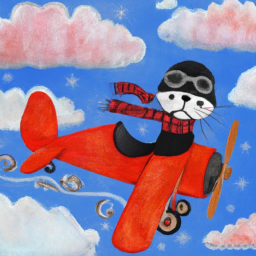

In [24]:
using Microsoft.DotNet.Interactive.OpenAI;

var dallEKernel = Kernel.Root.FindKernels(k => k is ImageGenerationKernel).Single();
await dallEKernel.SendAsync(new SubmitCode(prompts.Last()));

In [8]:
#!set --name person --value @input:"Enter the name of the person you'd like to summarize this text."
#!prompt function.writer.stylist

It takes messages, routes them to subkernels, and can format returned data
Messages are initiated via a host
Subkernels can be a bunch of different languages (including Mermaid)
Subkernels can share data
Subkernels can be running in different processes or on different machines
We’d love your ideas on how we can leverage this for developers



Messages routed to subkernels, it takes. Format returned data, it can. Host, via a, initiated. Different languages, including Mermaid, subkernels can be a bunch of. Data, share can subkernels. Different processes or machines, on different, running can subkernels be. Ideas, we'd love your, how leverage this for developers can we.

In [ ]:
#!function explainer --skill writer
{{$input}} 

Summarize the text above in the style of Randall Munroe's Thing Explainer, using only words that are amongst the most common 500 english words


In [6]:
#!function detect_intent 
Intent detection examples start here:
Intent: Unknown:
    * save
    * send
Intent: Help:
    * How can you help me?
    * What can you do?
Intent: TellAJoke:
    * What's the best joke you know?
    * Do you know any joke?
    * Tell me a joke
    * Tell me something funny
Intent: WhatTimeIsIt
    * tell me the time please
    * time and date please
    * what time is it?
    * what's the current time?
    * is it lunch time yet?
    * is it dinner time?
== end of examples ==
Input: {{$input}}
Intent:

In [8]:
#!prompt function._GLOBAL_FUNCTIONS_.detect_intent

I could really use some help understanding intent detection.

Help

In [14]:
#!prompt function.writer.explainer

Since .NET Interactive is capable of running as a kernel for notebooks, it enables a polyglot (multi-language) notebook experience. When using the .NET Interactive kernel, you can use different languages from one cell to the next, share variables between languages, and dynamically connect new languages and remote kernels within a notebook. There's no need to install different Jupyter kernels, use wrapper libraries, or install different tools to get the best experience for the language of your choice. You can always use the best language for the job and seamlessly transition between different stages of your workflow, all within one notebook.

For the best experience when working with multi-language notebooks, we recommend installing the Polyglot Notebooks extension for Visual Studio Code. While the full .NET Interactive feature set is available in Jupyter, many features are only usable via code, whereas the Polyglot Notebooks extension provides additional features including a language/kernel picker for each cell, enhanced language services, a multi-kernel variable viewer, and more.

Error: Microsoft.SemanticKernel.KernelException: FunctionNotAvailable: Function not available writer.explainer
   at Microsoft.SemanticKernel.SkillDefinition.SkillCollection.GetFunction(String skillName, String functionName)
   at Microsoft.SemanticKernel.SkillDefinition.ReadOnlySkillCollection.GetFunction(String skillName, String functionName)
   at Microsoft.DotNet.Interactive.OpenAI.TextCompletionKernel.Microsoft.DotNet.Interactive.IKernelCommandHandler<Microsoft.DotNet.Interactive.Commands.SubmitCode>.HandleAsync(SubmitCode submitCode, KernelInvocationContext context) in C:\dev\interactive\src\Microsoft.DotNet.Interactive.OpenAI\TextCompletionKernel.cs:line 82
   at Microsoft.DotNet.Interactive.Kernel.HandleAsync(KernelCommand command, KernelInvocationContext context) in C:\dev\interactive\src\Microsoft.DotNet.Interactive\Kernel.cs:line 325
   at Microsoft.DotNet.Interactive.KernelCommandPipeline.<BuildPipeline>b__6_0(KernelCommand command, KernelInvocationContext context, KernelPipelineContinuation _) in C:\dev\interactive\src\Microsoft.DotNet.Interactive\KernelCommandPipeline.cs:line 60
   at Microsoft.DotNet.Interactive.KernelCommandPipeline.SendAsync(KernelCommand command, KernelInvocationContext context) in C:\dev\interactive\src\Microsoft.DotNet.Interactive\KernelCommandPipeline.cs:line 41

In [ ]:
#!openai(embedding) --name fact1

My name is Inigo Montoya.

In [ ]:
#!openai(embedding) --name fact2 

You killed my father.

## Comparing models

In [12]:
Here are some resturants I would like to eat at in Mexico City between April 27 and May 3. 

* Maximo Bistro Tencui
* Mi Compa Chava Mariscos Contramar
* Paramo
* Masala y Maiz
* Limosneros
* Nicos
* El Hidalguense

Which ones will I not need reservations for?

You will not need reservations for Maximo Bistro Tencui, Masala y Maiz, Limosneros, and El Hidalguense.

In [13]:
Here are some resturants I would like to eat at in Mexico City between April 27 and May 3. 

* Maximo Bistro Tencui
* Mi Compa Chava Mariscos Contramar
* Paramo
* Masala y Maiz
* Limosneros
* Nicos
* El Hidalguense

Which ones will I not need reservations for?

It is recommended to make reservations for all of these restaurants, especially during the dates of your visit. It is best to contact each restaurant directly to inquire about their reservation policies and availability.

In [4]:
System.Diagnostics.Debugger.Launch();